# Contact maps and clustering of Galpha trajectories
### Metadynamics with CMAP and angle

In [2]:
import mdtraj as md
import pyemma
import numpy as np

import pandas as pd
import pickle
import os
import matplotlib
import matplotlib.pyplot as plt
import pyemma.plots as mplt

## Read trajectories and calculate distances

In [3]:
# define name of gro file for topology
# define set of trajectories

topname = "both/Ga.pdb"
folder = 'both'
traj_list = [f'{folder}/prod.{i}.xtc' for i in [1,2]]
stride=10
ligand_name='GSP'


In [4]:
if True:
    ## identify residues to use for the clustering
    top=md.load(topname)
    feat = pyemma.coordinates.featurizer(top.topology) 
    
    selected_res=[]
    for i,resi in enumerate(top.topology.residues):
        if (resi.resSeq>38) and (i % 3 == 0) and (not resi.name=='MG') and (not resi.name==ligand_name):
            print((i,resi,resi.resSeq,resi.name))
            selected_res.append(i)
    
    print(f'{len(selected_res)} residues selected for clustering')
    pairs = [[i,j] for i in selected_res for j in selected_res if i>j]
    
    print(f'{len(pairs)} pairs selected for clustering')
    feat.add_residue_mindist(residue_pairs=np.array(pairs),ignore_nonprotein=False)

(30, ALA39, 39, 'ALA')
(33, ARG42, 42, 'ARG')
(36, LEU45, 45, 'LEU')
(39, ALA48, 48, 'ALA')
(42, SER51, 51, 'SER')
(45, SER54, 54, 'SER')
(48, VAL57, 57, 'VAL')
(51, MET60, 60, 'MET')
(54, LEU63, 63, 'LEU')
(57, ASN66, 66, 'ASN')
(60, ASN69, 69, 'ASN')
(63, SER72, 72, 'SER')
(66, ALA89, 89, 'ALA')
(69, VAL92, 92, 'VAL')
(72, ILE95, 95, 'ILE')
(75, ASN98, 98, 'ASN')
(78, GLU101, 101, 'GLU')
(81, GLU104, 104, 'GLU')
(84, VAL107, 107, 'VAL')
(87, MET110, 110, 'MET')
(90, LEU113, 113, 'LEU')
(93, PRO116, 116, 'PRO')
(96, LEU119, 119, 'LEU')
(99, PRO122, 122, 'PRO')
(102, GLN125, 125, 'GLN')
(105, VAL128, 128, 'VAL')
(108, ILE131, 131, 'ILE')
(111, VAL134, 134, 'VAL')
(114, VAL137, 137, 'VAL')
(117, PHE140, 140, 'PHE')
(120, PRO143, 143, 'PRO')
(123, PHE146, 146, 'PHE')
(126, HIS149, 149, 'HIS')
(129, ALA152, 152, 'ALA')
(132, GLU155, 155, 'GLU')
(135, GLY158, 158, 'GLY')
(138, ALA161, 161, 'ALA')
(141, GLU164, 164, 'GLU')
(144, ASN167, 167, 'ASN')
(147, GLN170, 170, 'GLN')
(150, ASP173, 17

In [5]:
if True:
    reader = pyemma.coordinates.source(traj_list, features=feat) 
    data=reader.get_output(stride=stride)
    ## save contacts
    import pickle
    with open(f'contacts_stride_{stride}.pck','wb') as fileout:
        pickle.dump(data,fileout)

else:
    with open(f'contacts_stride_{stride}.pck','rb') as filein:
        data = pickle.load(filein)
        

In [6]:
#match frames with plumed CVs and weigths

## new_angle is calculated from xtc, so only the stride in this notebook has to be accounted for
cvs1_raw = [np.loadtxt(f'{folder}/COLVAR.all.{i}.add') for i in [1,2]]
cvs1 = [cv[::stride,:] for cv in cvs1_raw]

## original cvs are calculated on the fly in plumed, so there is an additional 5000/1000 factore due to cv printing
#cvs2_raw = [np.loadtxt(f'{folder}/reweight_factors{i}.txt') for i in [1,2,3,4,5]]
#cvs2 = [cv[::(stride*5),:] for cv in cvs2_raw]




In [7]:
pd.DataFrame({
    'frames_xtc': [dt.shape[0] for dt in data],
    'cv': [dt.shape[0] for dt in cvs1]    
})


,frames_xtc,cv
0,13609,13609
1,11315,11315


## Do clustering of contact distances using TICA and k-means

In [8]:
def shift(x,x0,b):
    wex=np.exp(-b*(x-x0))
    return wex/(1+wex)
contacts = [shift(dt,0.8,15) for dt in data]

In [9]:
#stride 10, lag 10,  -- works
#projected_data = pyemma.coordinates.tica(data, dim=5, lag=10)
projected_data = pyemma.coordinates.pca(data, dim=10)

In [10]:
projected_data2 = projected_data.get_output()

In [11]:
w_reweights = [np.exp(cv[:,4]/2.5) for cv in cvs1]

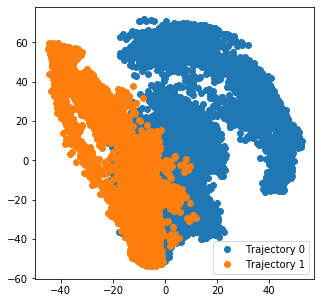

In [12]:
plt.figure(figsize=(5,5))
for i, prjd in enumerate(projected_data2):
    plt.plot(prjd[:,1],prjd[:,0],marker='o',linewidth=0, label=f'Trajectory {i}')
plt.legend()


In [13]:
def plotfes(i):
    plt.figure(figsize=(5,5))
    mplt.plot_free_energy(
        projected_data2[i][:,0], 
        projected_data2[i][:,1],
        weights = w_reweights[i],
        cmap='nipy_spectral')
    plt.plot(projected_data2[i][0,0],projected_data2[i][0,1],marker='o',markersize=9,color='magenta')
    plt.xlim(-60,70)
    plt.ylim(-50,50)

<Figure size 360x360 with 0 Axes>

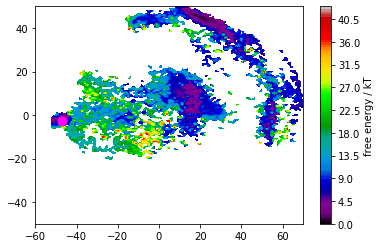

In [14]:
plotfes(0)

<Figure size 360x360 with 0 Axes>

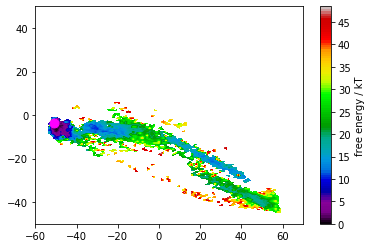

In [15]:
plotfes(1)

In [16]:
clustering = pyemma.coordinates.cluster_kmeans(projected_data2,k=10,max_iter=100)

In [17]:
def plot_fesclust(i):
    plt.figure(figsize=(5,5))
    mplt.plot_free_energy(
        projected_data2[i][:,0], 
        projected_data2[i][:,1],
        weights = w_reweights[i],
        cmap='nipy_spectral')

    if True:
        cc_x = clustering.clustercenters[:,0]
        cc_y = clustering.clustercenters[:,1]
        plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=9, color='lightgray')

    #for tica_traj in projected_data2:
    #    plt.plot(tica_traj[0:1,0],tica_traj[0:1,1],marker='x',linewidth=0,c='cyan')
    #    plt.plot(tica_traj[-1:,0],tica_traj[-1:,1],marker='x',linewidth=0,c='blue')


<Figure size 360x360 with 0 Axes>

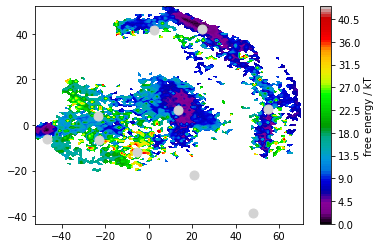

In [18]:
plot_fesclust(0)

<Figure size 360x360 with 0 Axes>

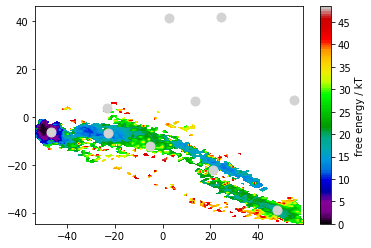

In [19]:
plot_fesclust(1)

In [20]:
angle1 = [cv[:,1]*180/np.pi for cv in cvs1]
angle2 = [cv[:,5]*180/np.pi for cv in cvs1]
cmap = [cv[:,2] for cv in cvs1]

angle1_st = np.concatenate(angle1)
angle2_st = np.concatenate(angle2)
angle3_st = angle2_st+ 360*(np.rint(angle2_st/180)<0)

angle3 = [ang2 + 360*(np.rint(ang2/180)<0) for ang2 in angle2]

cmap_st = np.concatenate(cmap)
dtraj_st = np.concatenate(clustering.dtrajs)

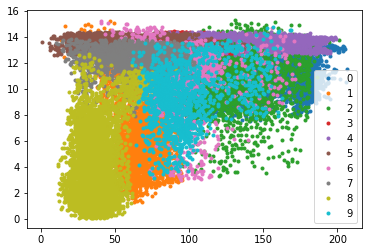

In [21]:
for cluster in range(max(dtraj_st)+1):
    frames = dtraj_st==cluster
    plt.plot(angle3_st[frames],cmap_st[frames], label=f'{cluster}', marker='.', linewidth=0)

plt.legend()

#frames = clustering.dtrajs[0]==0
#plt.plot(colvar[frames,1],colvar[frames,2], label=f'{cluster}', marker='x', linewidth=0)
plt.savefig("cvs_cluster.pdf")

In [22]:
def plot_fescvs(i):
    plt.figure(figsize=(10,5))
    mplt.plot_free_energy(
        angle3[i],
        cmap[i],
        weights = w_reweights[i],
        cmap='nipy_spectral',nbins=50)
    plt.xlim(0,200)
    plt.ylim(0,16)

    #if True:
    #    cc_x = clustering.clustercenters[:,0]
    #    cc_y = clustering.clustercenters[:,1]
    #    plt.plot(cc_x,cc_y, linewidth=0, marker='o', markersize=9, color='lightgray')


<Figure size 720x360 with 0 Axes>

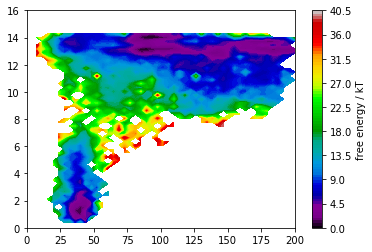

In [23]:
plot_fescvs(0)

<Figure size 720x360 with 0 Axes>

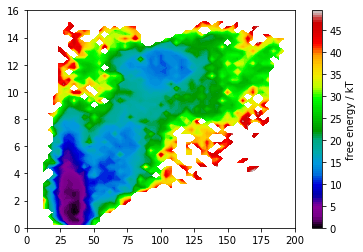

In [24]:
plot_fescvs(1)

In [25]:
trj_ID  = np.concatenate((0*angle1[0],1+0*angle1[1]))

In [26]:
pd.DataFrame(
{
    'angle1_st':angle1_st,
    'angle2_st':angle2_st,
    'angle3_st': angle3_st,
    'cmap_st': cmap_st,
    'dtraj_st': dtraj_st,
    'weight': np.concatenate(w_reweights),
    'ID':trj_ID

}).to_csv("trajs_csv.csv")

In [27]:
def sample_by_cluster(cluster_number,size=10):
    frames_representative = []
    for i,cl_dtrj in enumerate(clustering.dtrajs):
        all_frames=np.where(cl_dtrj==cluster_number)[0]
        probs = w_reweights[i][all_frames]
        probs = probs/sum(probs)
        print(sum(probs))
        if(sum(probs)>0):
            selected_frames = np.random.choice(
                all_frames,
                size=min(size,len(all_frames)),
                p=probs,
                replace=False)
            if(len(selected_frames)>0):
                frames_representative.append(np.array([[i, fr] for fr in selected_frames]))
    return frames_representative


def save_sample_by_cluster(cluster_number,size=10):
    samples = sample_by_cluster(cluster_number,size=size)
    print([len(t) for t in samples])
    pyemma.coordinates.save_traj(
        reader, 
        samples,
        outfile=f'cluster_rep_{cluster_number}.xtc',
        stride=stride)
    np.savetxt(f'cluster_rep_{cluster_number}.frames',np.vstack(samples))

In [28]:
    top0=md.load("both/Ga.pdb")
    feat0 = pyemma.coordinates.featurizer(top0.topology)
    reader0 = pyemma.coordinates.source(["both/prod.1.xtc"],features=feat0)
    
    top1=md.load("Gabg/em.no_wat.pdb")
    feat1 = pyemma.coordinates.featurizer(top1.topology)
    reader1 = pyemma.coordinates.source(["Gabg/prod.Gabg.xtc"],features=feat1)

In [29]:
readers = [reader0, reader1]

def save_sample_by_cluster(cluster_number,size=10):
    samples = sample_by_cluster(cluster_number,size=size)
    print([len(t) for t in samples])
    
    for sys_ID, frames in enumerate(samples):
        if(len(frames)>0):
            frames[:,0]=0*frames[:,0]
            print(frames)
            pyemma.coordinates.save_traj(
                readers[sys_ID], 
                frames,
                outfile=f'cluster_rep_{sys_ID}_{cluster_number}.xtc',
                stride=stride)
            np.savetxt(f'cluster_rep_{sys_ID}_{cluster_number}.frames',frames)

In [30]:
for cluster in range(max(dtraj_st)+1):
    save_sample_by_cluster(cluster, size=10)

0.9999999999999999
0.9999999999999997
[10, 10]
[[   0 7021]
 [   0 5034]
 [   0 7315]
 [   0 7202]
 [   0 7366]
 [   0 7206]
 [   0 7414]
 [   0 6903]
 [   0 7370]
 [   0 7306]]
30-06-20 16:10:05 pyemma.coordinates.api INFO     Created file cluster_rep_0_0.xtc
[[   0 4254]
 [   0 4244]
 [   0 4281]
 [   0 4224]
 [   0 4277]
 [   0 4225]
 [   0 4251]
 [   0 4275]
 [   0 4242]
 [   0 4278]]
30-06-20 16:10:05 pyemma.coordinates.api INFO     Created file cluster_rep_1_0.xtc
1.000000000000002
1.000000000000001
[10, 10]
[[   0  127]
 [   0  125]
 [   0  133]
 [   0  130]
 [   0 1630]
 [   0 1682]
 [   0  131]
 [   0 1609]
 [   0 1947]
 [   0 1638]]
30-06-20 16:10:06 pyemma.coordinates.api INFO     Created file cluster_rep_0_1.xtc
[[   0 6803]
 [   0 7390]
 [   0 7287]
 [   0 7227]
 [   0 7230]
 [   0 7205]
 [   0 7252]
 [   0 7386]
 [   0 7153]
 [   0 7170]]
30-06-20 16:10:06 pyemma.coordinates.api INFO     Created file cluster_rep_1_1.xtc
0
0.9999999999999998
[10]
[[    0 10870]
 [    0 108

In [31]:
import mdtraj as md

In [32]:
for cluster in range(max(dtraj_st)+1):
    t1=md.load(f'cluster_rep_0_{cluster}.xtc',top=feat0.topology)
    t1.save_dcd(f'cluster_rep_0_{cluster}.dcd')

In [33]:
for cluster in range(max(dtraj_st)+1):
    t1=md.load(f'cluster_rep_1_{cluster}.xtc',top=feat1.topology)
    t1.save_dcd(f'cluster_rep_1_{cluster}.dcd')

OSError: No such file: cluster_rep_1_2.xtc